In [1]:
#remeber to run " export CUDA_VISIBLE_DEVICES=3 " and then " jupyter notebook " on the terminal after activating env diffusion
import os
gpu="3"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu #change 4: add this line in every cell 

In [2]:
#Data loader
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import xarray as xr 

path_GT="/DATASET/data_nga/Delft3Dmodel_CMEMS_size200T300/Deflt3D/GT_Delft3D_size200T300_log10.nc"
path_land="/DATASET/data_nga/Delft3Dmodel_CMEMS_size200T300/Deflt3D/land_mask_Delft3D_size200T300.nc"
path_Obs="/DATASET/data_nga/Delft3Dmodel_CMEMS_size200T300/Deflt3D/Obs_patch_Delft3D_size200T300_log10_0.5NoCloud.nc"

GT=xr.open_dataset(path_GT)
print("GT: ", GT)
# Select the subset of data
GT_subset = GT.isel(lat=slice(94, 150), lon=slice(0, 56))

# Print the subset dataset information
print("GT_subset: ",GT_subset)

import numpy as np
print(np.unique(GT_subset.SPM))

GT:  <xarray.Dataset> Size: 351MB
Dimensions:  (time: 732, lat: 200, lon: 300)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2016-01-01 2016-01-02 ... 2018-01-01
  * lat      (lat) float64 2kB 52.55 52.56 52.57 52.57 ... 53.96 53.96 53.97
  * lon      (lon) float64 2kB 5.229 5.236 5.243 5.25 ... 7.345 7.352 7.359
Data variables:
    SPM      (time, lat, lon) float64 351MB ...
GT_subset:  <xarray.Dataset> Size: 18MB
Dimensions:  (time: 732, lat: 56, lon: 56)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2016-01-01 2016-01-02 ... 2018-01-01
  * lat      (lat) float64 448B 53.22 53.23 53.24 53.24 ... 53.6 53.61 53.62
  * lon      (lon) float64 448B 5.229 5.236 5.243 5.25 ... 5.6 5.607 5.614 5.621
Data variables:
    SPM      (time, lat, lon) float64 18MB ...
[-1.         -1.         -1.         ...  3.88130576  4.00000434
         nan]


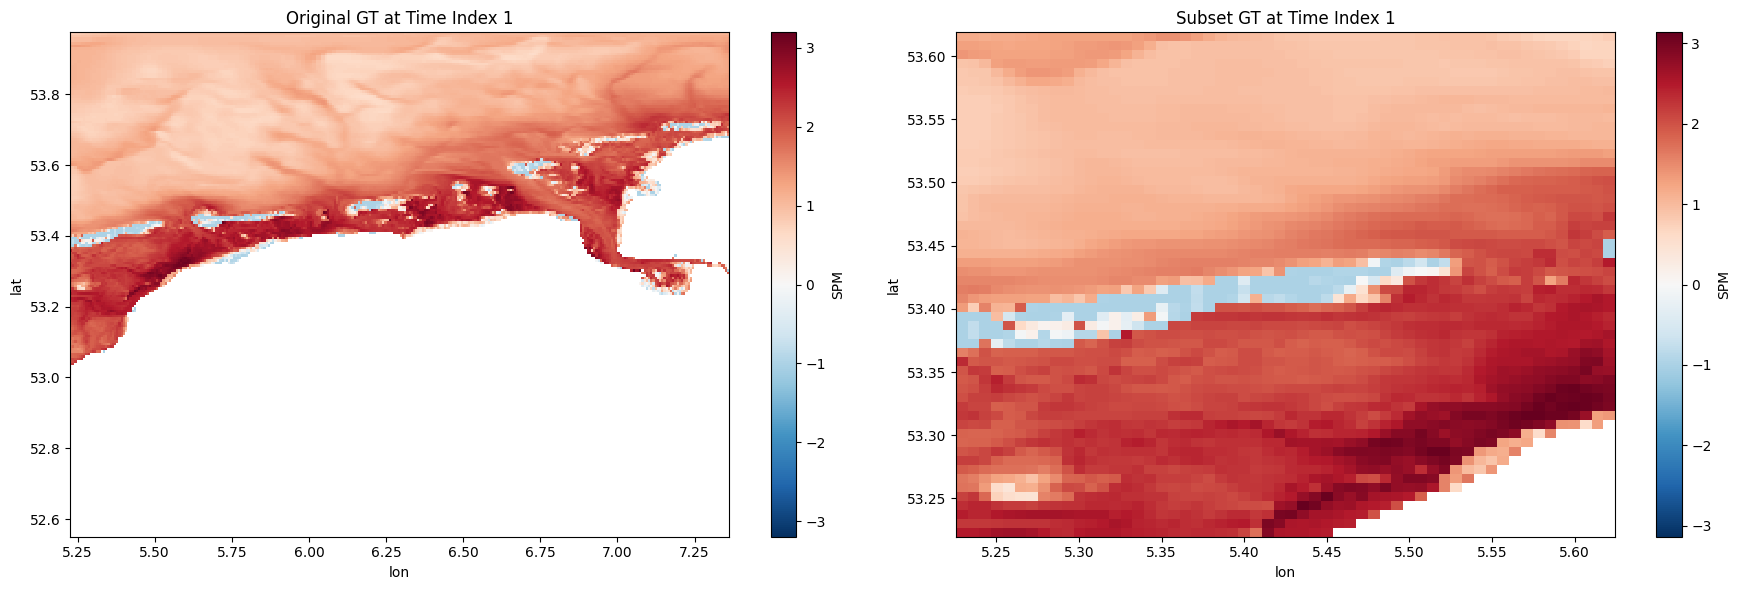

In [3]:
#plot GT and GT_subset
import matplotlib.pyplot as plt
# Select the data for a specific time index
GT_time1 = GT.isel(time=1)
GT_subset_time1 = GT_subset.isel(time=1)

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot the original data for time=1
GT_time1.SPM.plot(ax=axes[0])
axes[0].set_title('Original GT at Time Index 1')

# Plot the subset data for time=1
GT_subset_time1.SPM.plot(ax=axes[1])
axes[1].set_title('Subset GT at Time Index 1')

# Show the plots
plt.tight_layout()
plt.show()

In [4]:
#now take GT=GT_subset
GT=GT_subset

In [14]:
import random
import torch

#change 18a: create a mask for simulating artificially the gaps
def create_mask(image_size,rect):
    """
    Create a mask for inpainting.

    Parameters:
    - image_size: (height, width) of the image
    - rect: (x, y, width, height) of the rectangle to inpaint

    Returns:
    - mask: A binary tensor of the same size as the image
    """
    mask = torch.zeros(image_size)
    x, y, w, h = rect
    mask[y:y+h, x:x+w] = 1
    return mask

def generate_random_box(image_size, area_ratio=0.25):
    """
    Generate a random box within the image.

    Parameters:
    - image_size: (height, width) of the image
    - area_ratio: The area ratio of the box relative to the image (default is 0.25)

    Returns:
    - (x_start, y_start, width, height): Tuple representing the box
    """
    img_height, img_width = image_size
    image_area = img_height * img_width
    
    # Desired box area
    box_area = image_area * area_ratio
    
    # Generate random width and height for the box
    # We need to ensure that width * height = box_area approximately
    # We can do this by randomly choosing a width and calculating the height
    width = random.randint(int(img_width * 0.2), int(img_width * 0.8))
    height = int(box_area / width)
    
    if height > img_height:
        height = img_height

    # Randomly choose the top-left corner of the box
    x_start = random.randint(0, img_width - width)
    y_start = random.randint(0, img_height - height)
    
    return (x_start, y_start, width, height)


In [6]:
############ #change 5: Dataloader with crop size 28*28,  need to change it later on to have bigger size

import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import torchvision.transforms as transforms
import numpy as np

class XArrayDatasetWithCrop(Dataset):
    
    def __init__(self, GT, crop_size, output_size, transform=None):
        self.dataset = GT
        self.data = self.dataset['SPM'].values  # Assuming 'SPM' is your target variable
        self.crop_size = crop_size
        self.output_size = output_size
        self.transform = transform
        self.random_crop = transforms.RandomCrop(crop_size)  # Define the random crop
        self.resize = transforms.Resize(output_size)  # Define the resize transformation


    def __len__(self): #change 8: can modify the len here to have more image per epoch
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Extract the data for the given time step
        sample = self.data[idx]  # Shape: (lat, lon)
        
        # Convert to tensor (required for torchvision transforms)
        sample = torch.tensor(sample, dtype=torch.float32)
        
        # Add channel dimension (assuming single-channel data)
        sample = sample.unsqueeze(0)  # Shape: (1, lat, lon)
        
        # Apply random cropping
        # sample = self.random_crop(sample)  # Shape: (1, crop_size[0], crop_size[1])
        #change 13: Fixed cropping to the left upper corner
        crop_height, crop_width = self.crop_size
        sample = sample[:, :crop_height, :crop_width]  # Crop the top-left corner


        # Apply resizing to match the MNIST size
        sample = self.resize(sample)  # Shape: (1, output_size[0], output_size[1])
        
        # Apply additional transforms if provided
        if self.transform:
            sample = self.transform(sample)
        
        return sample


# Define your dataset
crop_size=(56, 56)#change 16: you can change crop_size and output_size here
output_size=(28, 28)
dataset = XArrayDatasetWithCrop(GT, crop_size=crop_size, output_size=output_size)

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Test the DataLoader
for batch in data_loader:
    print(batch.shape)  # Should print (32, 1, crop_size0, crop_size1)
    break


torch.Size([32, 1, 28, 28])


In [7]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = gpu

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [8]:
#@title Set up the SDE
import functools  # Import the functools module
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [15]:
#@title Define the loss function (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

#change 7: customize the loss to adress NaN values following below 4 steps, but can be fasten process by adding the mask inside the loss function inputs !!!!!
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """

  # ###original loss
  # random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  # z = torch.randn_like(x)
  # std = marginal_prob_std(random_t)
  # perturbed_x = x + z * std[:, None, None, None]
  # score = model(perturbed_x, random_t)
  # loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))

  # Step 1: Replace NaN values with zero
  mask_NonNaN = ~torch.isnan(x)  # mask is True where x is not NaN
  x = torch.nan_to_num(x, nan=0.0)  # Replace NaNs with 0
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)

  #change 18b: modify the perturbed_x with mask
  box = generate_random_box(x.shape[-2:], area_ratio=0.25)
  mask_gap = create_mask(x.shape[-2:], box).to(x.device)  # Ensure mask_gap is on the same device
  # During the forward diffusion process
  perturbed_x = x * (1 - mask_gap) + (x + z * std[:, None, None, None]) * mask_gap
  score_model_output = model(perturbed_x, random_t)
  
  # perturbed_x = x + z * std[:, None, None, None]
  
  
  # Step 2: Compute the loss as usual
  # loss = (score_model_output * std[:, None, None, None] + z) ** 2
  #change 18c: process the loss only on the mask_gap areas
  loss = (score_model_output * std[:, None, None, None] + z)**2 * mask_gap

  
  # Step 3: Apply the mask_NaN and compute loss only inside mask_NaN
  loss = loss * mask_NonNaN.float()  # Only consider non-NaN pixels
  
  # Step 4: Compute the mean loss over valid pixels
  loss = torch.sum(loss, dim=(1, 2, 3))  # Sum over spatial dimensions
  valid_pixel_count = torch.sum(mask_NonNaN, dim=(1, 2, 3))  # Count valid pixels
  loss = loss / valid_pixel_count  # Normalize loss by valid pixel count
  loss = torch.mean(loss)  # Average over the batch


  return loss

In [16]:
#@title Training (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
#from tqdm.notebook import trange
from tqdm import trange ##change 1: because tqdm.notebook import trange doesn't work 

n_epochs =   500#@param {'type':'integer'}#change 2: i changed 50 to 1 so that it run faster
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}#change 3: reduce batchsize from 32 to 8
## learning rate
lr=1e-4 #@param {'type':'number'}


## change 17: Check if the checkpoint exists
checkpoint_path = 'ckpt_Gappy.pth'

if os.path.exists(checkpoint_path):
    # Load the pre-trained checkpoint from disk
    ckpt = torch.load(checkpoint_path, map_location=device)
    
    # Inspect the checkpoint dictionary to see what keys it contains
    print("Checkpoint keys:", ckpt.keys())
    
    # Initialize the model
    score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)
    
    # Load the model state dictionary
    if 'model_state_dict' in ckpt:
        score_model.load_state_dict(ckpt['model_state_dict'])
    else:
        # If the checkpoint doesn't have 'model_state_dict', assume it contains the model state directly
        score_model.load_state_dict(ckpt)

    # Create the optimizer and load its state
    optimizer = Adam(score_model.parameters(), lr=lr)
    if 'optimizer_state_dict' in ckpt:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

    # Retrieve the last epoch
    start_epoch = ckpt.get('epoch', -1) + 1

    print(f"Checkpoint loaded, resuming training from epoch {start_epoch}")
else:
    # If no checkpoint exists, initialize the model from scratch
    score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)
    optimizer = Adam(score_model.parameters(), lr=lr)
    start_epoch = 0  # Start training from the first epoch

    print("No checkpoint found, starting training from scratch")




#change 14: Split your dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size   # 20% validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders for both training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


#change 5: we used our own data loader here 
# dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# optimizer = Adam(score_model.parameters(), lr=lr) #change 17: remove here because already have above
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    score_model.train()  # Set model to training mode
    for x in train_loader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Print the averaged training loss only every 10 epochs
    if epoch % 10 == 0:
        tqdm_epoch.set_description('Epoch: {} Average Loss: {:5f}'.format(epoch, avg_loss / num_items))


    # Validation step
    score_model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_loss = 0.
        val_items = 0
        for x in val_loader:
            x = x.to(device)
            loss = loss_fn(score_model, x, marginal_prob_std_fn)

            val_loss += loss.item() * x.shape[0]
            val_items += x.shape[0]

        avg_val_loss = val_loss / val_items
        # Print the validation loss only every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Validation Loss: {avg_val_loss:.5f}")

    # Optionally, save the model checkpoint
    torch.save(score_model.state_dict(), 'ckpt_Gappy.pth')



No checkpoint found, starting training from scratch


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_410240/3315192203.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Epoch: 0 Average Loss: 2.503012:   0%|          | 1/500 [00:03<29:34,  3.56s/it]

Epoch: 0 Validation Loss: 1.84725


Epoch: 10 Average Loss: 0.361741:   2%|▏         | 11/500 [00:07<03:32,  2.30it/s]

Epoch: 10 Validation Loss: 0.37522


Epoch: 20 Average Loss: 0.197386:   4%|▍         | 21/500 [00:12<03:26,  2.32it/s]

Epoch: 20 Validation Loss: 0.16257


Epoch: 30 Average Loss: 0.121766:   6%|▌         | 31/500 [00:16<03:11,  2.45it/s]

Epoch: 30 Validation Loss: 0.12471


Epoch: 40 Average Loss: 0.092450:   8%|▊         | 41/500 [00:20<03:15,  2.35it/s]

Epoch: 40 Validation Loss: 0.08364


Epoch: 50 Average Loss: 0.076447:  10%|█         | 51/500 [00:24<03:10,  2.36it/s]

Epoch: 50 Validation Loss: 0.07886


Epoch: 60 Average Loss: 0.055896:  12%|█▏        | 61/500 [00:29<03:15,  2.24it/s]

Epoch: 60 Validation Loss: 0.04760


Epoch: 70 Average Loss: 0.049974:  14%|█▍        | 71/500 [00:33<03:00,  2.38it/s]

Epoch: 70 Validation Loss: 0.05456


Epoch: 80 Average Loss: 0.042423:  16%|█▌        | 81/500 [00:37<03:03,  2.29it/s]

Epoch: 80 Validation Loss: 0.03563


Epoch: 90 Average Loss: 0.036410:  18%|█▊        | 91/500 [00:42<03:02,  2.24it/s]

Epoch: 90 Validation Loss: 0.03478


Epoch: 100 Average Loss: 0.029178:  20%|██        | 101/500 [00:46<02:51,  2.33it/s]

Epoch: 100 Validation Loss: 0.03080


Epoch: 110 Average Loss: 0.025601:  22%|██▏       | 111/500 [00:51<03:03,  2.12it/s]

Epoch: 110 Validation Loss: 0.02834


Epoch: 120 Average Loss: 0.021121:  24%|██▍       | 121/500 [00:55<02:51,  2.21it/s]

Epoch: 120 Validation Loss: 0.01904


Epoch: 130 Average Loss: 0.020924:  26%|██▌       | 131/500 [01:00<02:40,  2.30it/s]

Epoch: 130 Validation Loss: 0.02275


Epoch: 140 Average Loss: 0.024338:  28%|██▊       | 141/500 [01:04<02:35,  2.30it/s]

Epoch: 140 Validation Loss: 0.01792


Epoch: 150 Average Loss: 0.020547:  30%|███       | 151/500 [01:08<02:35,  2.24it/s]

Epoch: 150 Validation Loss: 0.01346


Epoch: 160 Average Loss: 0.020451:  32%|███▏      | 161/500 [01:13<02:32,  2.23it/s]

Epoch: 160 Validation Loss: 0.01776


Epoch: 170 Average Loss: 0.018679:  34%|███▍      | 171/500 [01:17<02:25,  2.26it/s]

Epoch: 170 Validation Loss: 0.01230


Epoch: 180 Average Loss: 0.019027:  36%|███▌      | 181/500 [01:22<02:23,  2.22it/s]

Epoch: 180 Validation Loss: 0.01108


Epoch: 190 Average Loss: 0.016521:  38%|███▊      | 191/500 [01:26<02:20,  2.19it/s]

Epoch: 190 Validation Loss: 0.01363


Epoch: 200 Average Loss: 0.012844:  40%|████      | 201/500 [01:30<02:08,  2.32it/s]

Epoch: 200 Validation Loss: 0.01305


Epoch: 210 Average Loss: 0.014507:  42%|████▏     | 211/500 [01:35<02:01,  2.37it/s]

Epoch: 210 Validation Loss: 0.01984


Epoch: 220 Average Loss: 0.015123:  44%|████▍     | 221/500 [01:39<01:55,  2.42it/s]

Epoch: 220 Validation Loss: 0.01966


Epoch: 230 Average Loss: 0.013624:  46%|████▌     | 231/500 [01:43<01:53,  2.36it/s]

Epoch: 230 Validation Loss: 0.01471


Epoch: 240 Average Loss: 0.015330:  48%|████▊     | 241/500 [01:47<01:51,  2.32it/s]

Epoch: 240 Validation Loss: 0.01360


Epoch: 250 Average Loss: 0.012071:  50%|█████     | 251/500 [01:52<01:45,  2.37it/s]

Epoch: 250 Validation Loss: 0.01504


Epoch: 260 Average Loss: 0.012404:  52%|█████▏    | 261/500 [01:56<01:41,  2.35it/s]

Epoch: 260 Validation Loss: 0.01499


Epoch: 270 Average Loss: 0.011876:  54%|█████▍    | 271/500 [02:00<01:34,  2.42it/s]

Epoch: 270 Validation Loss: 0.01168


Epoch: 280 Average Loss: 0.012059:  56%|█████▌    | 281/500 [02:04<01:30,  2.43it/s]

Epoch: 280 Validation Loss: 0.01168


Epoch: 290 Average Loss: 0.011268:  58%|█████▊    | 291/500 [02:08<01:26,  2.42it/s]

Epoch: 290 Validation Loss: 0.01634


Epoch: 300 Average Loss: 0.011466:  60%|██████    | 301/500 [02:12<01:23,  2.40it/s]

Epoch: 300 Validation Loss: 0.01428


Epoch: 310 Average Loss: 0.010423:  62%|██████▏   | 311/500 [02:17<01:18,  2.41it/s]

Epoch: 310 Validation Loss: 0.00800


Epoch: 320 Average Loss: 0.009797:  64%|██████▍   | 321/500 [02:21<01:16,  2.33it/s]

Epoch: 320 Validation Loss: 0.01108


Epoch: 330 Average Loss: 0.010976:  66%|██████▌   | 331/500 [02:25<01:15,  2.23it/s]

Epoch: 330 Validation Loss: 0.00607


Epoch: 340 Average Loss: 0.012019:  68%|██████▊   | 341/500 [02:30<01:18,  2.03it/s]

Epoch: 340 Validation Loss: 0.01183


Epoch: 350 Average Loss: 0.009933:  70%|███████   | 351/500 [02:35<01:07,  2.19it/s]

Epoch: 350 Validation Loss: 0.01412


Epoch: 360 Average Loss: 0.010102:  72%|███████▏  | 361/500 [02:39<01:03,  2.17it/s]

Epoch: 360 Validation Loss: 0.00726


Epoch: 370 Average Loss: 0.010496:  74%|███████▍  | 371/500 [02:44<00:57,  2.24it/s]

Epoch: 370 Validation Loss: 0.00781


Epoch: 380 Average Loss: 0.009207:  76%|███████▌  | 381/500 [02:48<00:53,  2.23it/s]

Epoch: 380 Validation Loss: 0.00684


Epoch: 390 Average Loss: 0.010374:  78%|███████▊  | 391/500 [02:53<00:48,  2.23it/s]

Epoch: 390 Validation Loss: 0.01347


Epoch: 400 Average Loss: 0.010744:  80%|████████  | 401/500 [02:58<00:51,  1.94it/s]

Epoch: 400 Validation Loss: 0.01125


Epoch: 410 Average Loss: 0.010298:  82%|████████▏ | 411/500 [03:03<00:45,  1.94it/s]

Epoch: 410 Validation Loss: 0.01042


Epoch: 420 Average Loss: 0.008925:  84%|████████▍ | 421/500 [03:08<00:40,  1.95it/s]

Epoch: 420 Validation Loss: 0.00929


Epoch: 430 Average Loss: 0.011623:  86%|████████▌ | 431/500 [03:13<00:32,  2.09it/s]

Epoch: 430 Validation Loss: 0.00804


Epoch: 440 Average Loss: 0.008931:  88%|████████▊ | 441/500 [03:18<00:28,  2.04it/s]

Epoch: 440 Validation Loss: 0.00846


Epoch: 450 Average Loss: 0.006878:  90%|█████████ | 451/500 [03:23<00:22,  2.18it/s]

Epoch: 450 Validation Loss: 0.01186


Epoch: 460 Average Loss: 0.010480:  92%|█████████▏| 461/500 [03:27<00:16,  2.41it/s]

Epoch: 460 Validation Loss: 0.00916


Epoch: 470 Average Loss: 0.007033:  94%|█████████▍| 471/500 [03:31<00:12,  2.35it/s]

Epoch: 470 Validation Loss: 0.01033


Epoch: 480 Average Loss: 0.007738:  96%|█████████▌| 481/500 [03:35<00:07,  2.52it/s]

Epoch: 480 Validation Loss: 0.01003


Epoch: 490 Average Loss: 0.007789:  98%|█████████▊| 491/500 [03:40<00:04,  1.96it/s]

Epoch: 490 Validation Loss: 0.00867


Epoch: 490 Average Loss: 0.007789: 100%|██████████| 500/500 [03:44<00:00,  2.22it/s]


## Sampling with Numerical SDE Solvers
Recall that for any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w},
\end{align*}
the reverse-time SDE is given by
\begin{align*}
d \mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}}.
\end{align*}
Since we have chosen the forward SDE to be
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
The reverse-time SDE is given by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}
To sample from our time-dependent score-based model $s_\theta(\mathbf{x}, t)$, we first draw a sample from the prior distribution $p_1 \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2}(\sigma^{2} - 1) \mathbf{I}\bigg)$, and then solve the reverse-time SDE with numerical methods.

In particular, using our time-dependent score-based model, the reverse-time SDE can be approximated by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} s_\theta(\mathbf{x}, t) dt + \sigma^t d \bar{\mathbf{w}}
\end{align*}

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization to the SDE, replacing $dt$ with $\Delta t$ and $d \mathbf{w}$ with $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, g^2(t) \Delta t \mathbf{I})$. When applied to our reverse-time SDE, we can obtain the following iteration rule
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \sigma^{2t} s_\theta(\mathbf{x}_t, t)\Delta t + \sigma^t\sqrt{\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

In [14]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

## Sampling with Predictor-Corrector Methods

Aside from generic numerical SDE solvers, we can leverage special properties of our reverse-time SDE for better solutions. Since we have an estimate of the score of $p_t(\mathbf{x}(t))$ via the score-based model, i.e., $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_t(\mathbf{x}(t))$, we can leverage score-based MCMC approaches, such as Langevin MCMC, to correct the solution obtained by numerical SDE solvers.

Score-based MCMC approaches can produce samples from a distribution $p(\mathbf{x})$ once its score $\nabla_\mathbf{x} \log p(\mathbf{x})$ is known. For example, Langevin MCMC operates by running the following iteration rule for $i=1,2,\cdots, N$:
\begin{align*}
\mathbf{x}_{i+1} = \mathbf{x}_{i} + \epsilon \nabla_\mathbf{x} \log p(\mathbf{x}_i) + \sqrt{2\epsilon} \mathbf{z}_i,
\end{align*}
where $\mathbf{z}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $\epsilon > 0$ is the step size, and $\mathbf{x}_1$ is initialized from any prior distribution $\pi(\mathbf{x}_1)$. When $N\to\infty$ and $\epsilon \to 0$, the final value $\mathbf{x}_{N+1}$ becomes a sample from $p(\mathbf{x})$ under some regularity conditions. Therefore, given $s_\theta(\mathbf{x}, t) \approx \nabla_\mathbf{x} \log p_t(\mathbf{x})$, we can get an approximate sample from $p_t(\mathbf{x})$ by running several steps of Langevin MCMC, replacing $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ with $s_\theta(\mathbf{x}, t)$ in the iteration rule.

Predictor-Corrector samplers combine both numerical solvers for the reverse-time SDE and the Langevin MCMC approach. In particular, we first apply one step of numerical SDE solver to obtain $\mathbf{x}_{t-\Delta t}$ from $\mathbf{x}_t$, which is called the "predictor" step. Next, we apply several steps of Langevin MCMC to refine $\mathbf{x}_t$, such that $\mathbf{x}_t$ becomes a more accurate sample from $p_{t-\Delta t}(\mathbf{x})$. This is the "corrector" step as the MCMC helps reduce the error of the numerical SDE solver.

In [17]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

## Sampling with Numerical ODE Solvers

For any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}
there exists an associated ordinary differential equation (ODE)
\begin{align*}
d \mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt,
\end{align*}
such that their trajectories have the same mariginal probability density $p_t(\mathbf{x})$. Therefore, by solving this ODE in the reverse time direction, we can sample from the same distribution as solving the reverse-time SDE.
We call this ODE the *probability flow ODE*.

Below is a schematic figure showing how trajectories from this probability flow ODE differ from SDE trajectories, while still sampling from the same distribution.
![SDE and ODE](https://drive.google.com/uc?id=1CGFbtY2mCjlIY8pjvoGevfa_32d4b1dj)

Therefore, we can start from a sample from $p_T$, integrate the ODE in the reverse time direction, and then get a sample from $p_0$. In particular, for the SDE in our running example, we can integrate the following ODE from $t=T$ to $0$ for sample generation
\begin{align*}
d\mathbf{x} =  -\frac{1}{2}\sigma^{2t} s_\theta(\mathbf{x}, t) dt.
\end{align*}
This can be done using many black-box ODE solvers provided by packages such as `scipy`.

In [18]:
#@title Define the ODE sampler (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x





In [20]:
#@title Sampling (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
from torchvision.utils import make_grid
import time
## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_Gappy.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 10#@param {'type':'integer'} #change 10: I use 2 instead of 64 to make it faster
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

#change 18g: choose the mask sampler
# sampler =sampler_with_gappy

print("time 1 ", time.time())
# ## Generate samples using the specified sampler.
# samples = sampler(score_model,
#                   marginal_prob_std_fn,
#                   diffusion_coeff_fn,
#                   sample_batch_size,
#                   device=device)


#change 18e: take 1st initial image in validation set
val_loader = DataLoader(val_dataset, batch_size=sample_batch_size, shuffle=False, num_workers=4)
validation_batch = next(iter(val_loader))
# Select the first image from the validation batch
initial_image = validation_batch[0].to(device)

#change 18f: taking one image in validation, then generate the missing area only by making a random mask, then apply the mask to the initial image
# Step 1: 
image_size = (28, 28)  # Replace with your image size
box = generate_random_box(image_size, area_ratio=0.25)
mask = create_mask(image_size, box).to(device)
initial_image = initial_image * (1 - mask) + torch.randn_like(initial_image) * mask
initial_image = initial_image * (1 - mask) + torch.randn_like(initial_image) * mask
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  z=initial_image,
                  device=device)


print("time 2 ", time.time())

## Sample visualization.
# samples = samples.clamp(0.0, 1.0)#change 15: remove the round to plot the original values, and should multiply with 255

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title("Generated Images")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# Now, let's load the original images from the dataset and plot them
data_loader = DataLoader(dataset, batch_size=sample_batch_size, shuffle=True, num_workers=4)
original_images = next(iter(data_loader))  # Get a batch of original images

# Ensure that the images are on the same device
original_images = original_images.to(device)
# Convert the images to uint8 by scaling with 255
original_images_uint8 = (original_images * 255).byte()
# original_images = original_images.clamp(0.0, 1.0)

# Plot the original images
original_grid = make_grid(original_images_uint8, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title("Original Images")
plt.imshow(original_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3010803901.py, line 42)

In [19]:
# Assuming original_images is a tensor on the GPU
original_images_cpu = original_images.cpu()  # Move the tensor to the CPU
original_images_np = original_images_cpu.numpy()  # Convert the tensor to a NumPy array

# Now you can use np.unique on the NumPy array
print(" np.unique(original_images_np) : ", np.unique(original_images_np))

# Assuming original_images is a tensor on the GPU
samples_cpu = samples.cpu()  # Move the tensor to the CPU
samples_np = samples_cpu.numpy()  # Convert the tensor to a NumPy array

# Now you can use np.unique on the NumPy array
print("np.unique(samples_np): ", np.unique(samples_np))


 np.unique(original_images_np) :  [-0.99977773 -0.99961716 -0.99846625 ...  3.2038438   3.2656915
         nan]
np.unique(samples_np):  [-7.04224038 -6.54622036 -5.59253458 ...  5.18000508  5.1908841
  5.25755636]


## Likelihood Computation

A by-product of the probability flow ODE formulation is likelihood computation. Suppose we have a differentiable one-to-one mapping $\mathbf{h}$ that transforms a data sample $\mathbf{x} \sim p_0$ to a prior distribution $\mathbf{h}(\mathbf{x}) \sim p_T$. We can compute the likelihood of $p_0(\mathbf{x})$ via the following [change-of-variable formula](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function)
\begin{align*}
p_0(\mathbf{x}) = p_T(\mathbf{h}(\mathbf{x})) |\operatorname{det}(J_\mathbf{h}(\mathbf{x}))|,
\end{align*}
where $J_\mathbf{h}(\mathbf{x})$ represents the Jacobian of the mapping $\mathbf{h}$, and we assume it is efficient to evaluate the likelihood of the prior distribution $p_T$.

The trajectories of an ODE also define a one-to-one mapping from $\mathbf{x}(0)$ to $\mathbf{x}(T)$. For ODEs of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt,
\end{align*}
there exists an [instantaneous change-of-variable formula](https://arxiv.org/abs/1806.07366) that connects the probability of $p_0(\mathbf{x})$ and $p_1(\mathbf{x})$, given by
\begin{align*}
p_0 (\mathbf{x}(0)) = e^{\int_0^1 \operatorname{div} \mathbf{f}(\mathbf{x}(t), t) d t} p_1(\mathbf{x}(1)),
\end{align*}
where $\operatorname{div}$ denotes the divergence function (trace of Jacobian).

In practice, this divergence function can be hard to evaluate for general vector-valued function $\mathbf{f}$, but we can use an unbiased estimator, named [Skilling-Hutchinson estimator](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/), to approximate the trace. Let $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. The Skilling-Hutchinson estimator is based on the fact that
\begin{align*}
\operatorname{div} \mathbf{f}(\mathbf{x}) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_\mathbf{f}(\mathbf{x}) \boldsymbol\epsilon].
\end{align*}
Therefore, we can simply sample a random vector $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, and then use $\boldsymbol \epsilon^\intercal J_\mathbf{f}(\mathbf{x}) \boldsymbol \epsilon$ to estimate the divergence of $\mathbf{f}(\mathbf{x})$. This estimator only requires computing the Jacobian-vector product $J_\mathbf{f}(\mathbf{x})\boldsymbol \epsilon$, which is typically efficient.

As a result, for our probability flow ODE, we can compute the (log) data likelihood with the following
\begin{align*}
\log p_0(\mathbf{x}(0)) = \log p_1(\mathbf{x}(1)) -\frac{1}{2}\int_0^1 \frac{d[\sigma^2(t)]}{dt} \operatorname{div} s_\theta(\mathbf{x}(t), t) dt.
\end{align*}
With the Skilling-Hutchinson estimator, we can compute the divergence via
\begin{align*}
\operatorname{div} s_\theta(\mathbf{x}(t), t) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_{s_\theta}(\mathbf{x}(t), t) \boldsymbol\epsilon].
\end{align*}
Afterwards, we can compute the integral with numerical integrators. This gives us an unbiased estimate to the true data likelihood, and we can make it more and more accurate when we run it multiple times and take the average. The numerical integrator requires $\mathbf{x}(t)$ as a function of $t$, which can be obtained by the probability flow ODE sampler.

In [15]:
#@title Define the likelihood function (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=(1,2,3)) / (2 * sigma**2)

def ode_likelihood(x,
                   score_model,
                   marginal_prob_std,
                   diffusion_coeff,
                   batch_size=64,
                   device='cuda',
                   eps=1e-5):
  """Compute the likelihood with probability flow ODE.

  Args:
    x: Input data.
    score_model: A PyTorch model representing the score-based model.
    marginal_prob_std: A function that gives the standard deviation of the
      perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the
      forward SDE.
    batch_size: The batch size. Equals to the leading dimension of `x`.
    device: 'cuda' for evaluation on GPUs, and 'cpu' for evaluation on CPUs.
    eps: A `float` number. The smallest time step for numerical stability.

  Returns:
    z: The latent code for `x`.
    bpd: The log-likelihoods in bits/dim.
  """

  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)

  def divergence_eval(sample, time_steps, epsilon):
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    with torch.enable_grad():
      sample.requires_grad_(True)
      score_e = torch.sum(score_model(sample, time_steps) * epsilon)
      grad_score_e = torch.autograd.grad(score_e, sample)[0]
    return torch.sum(grad_score_e * epsilon, dim=(1, 2, 3))

  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = marginal_prob_std(1.)
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

In [16]:
#@title Compute likelihood on the dataset (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
from tqdm.notebook import tqdm #change 9: I add this line, and the line tqdm.notebook.tqdm(data_loader) by tqdm(data_loader)
# import tqdm
batch_size = 32 #@param {'type':'integer'}

dataset = MNIST('.', train=False, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

ckpt = torch.load('ckpt_Gappy.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds = 0.
all_items = 0
try:
  tqdm_data = tqdm(data_loader)
  for x, _ in tqdm_data:
    x = x.to(device)
    # uniform dequantization
    x = (x * 255. + torch.rand_like(x)) / 256.
    _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn,
                            x.shape[0], device=device, eps=1e-5)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    tqdm_data.set_description("Average bits/dim: {:5f}".format(all_bpds / all_items))

except KeyboardInterrupt:
  # Remove the error message when interuptted by keyboard or GUI.
  pass


  0%|          | 0/313 [00:00<?, ?it/s]

/tmp/ipykernel_3701833/3315192203.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
/tmp/ipykernel_3701833/3315192203.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
